In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/MyDrive/GAN_datasets/face_scrub.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38692_18105.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38693_18106.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38695_18108.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38699_18111.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38702_18113.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38704_18115.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38716_18119.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38728_18126.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38730_18127.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38748_18138.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38751_18140.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38753_18142.jpeg  
  inflating: /actress_faces/Olivia_d'Abo/Olivia_d'Abo_38755_18143.jpeg  


In [8]:
import glob
actors = glob.glob('/actor_faces/*/*.jpeg')
actress = glob.glob('/actress_faces/*/*.jpeg')

In [9]:
len(actors), len(actress)

(22809, 19387)

In [10]:
import cv2
for file in actors[:10]:
    img = cv2.imread(file)
    print (img.shape)

(239, 239, 3)
(107, 107, 3)
(169, 169, 3)
(147, 147, 3)
(449, 449, 3)
(250, 250, 3)
(615, 615, 3)
(162, 162, 3)
(345, 345, 3)
(164, 164, 3)


Male Actor Faces


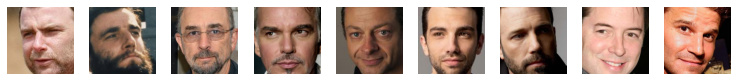

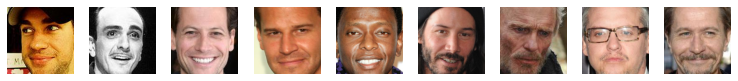

--------------------------------------------------------------------------------
Female Actress Faces


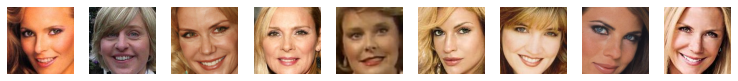

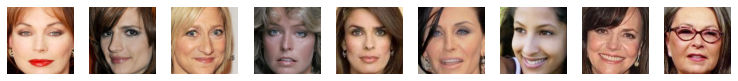

In [11]:
print ("Male Actor Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(actors)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Female Actress Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(actress)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [26]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [27]:
source_image_A = tensorflow.keras.layers.Input(shape=(128, 128, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(128, 128, 3))

def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, translated_image

source_image, translated_image = make_generator()
generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

source_image, translated_image = make_generator()
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

print (generator_network_AB.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 64, 64, 64)   3136        input_13[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_32 (LeakyReLU)      (None, 64, 64, 64)   0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 32, 128)  131200      leaky_re_lu_32[0][0]             
____________________________________________________________________________________________

# Discriminator Network

In [28]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [29]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

target_image_input, patch_features = make_discriminator()
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 256)       5245

In [30]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_B.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# DISCO-GAN

In [31]:
# Domain Transfer
fake_B = generator_network_AB(source_image_A)
fake_A = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A = generator_network_BA(fake_B)
get_back_B = generator_network_AB(fake_A)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

disco_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B], \
                              outputs = [verify_A, verify_B, fake_B, fake_A, get_back_A, get_back_B])
disco_gan.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 128, 128, 3)  41841283    input_12[0][0]                   
                                                                 model_7[0][0]                    
__________________________________________________________________________________________________
model_7 (Functional)            (None, 128, 128, 3)  41841283    input_11[0][0]            

# Compiling Models

In [32]:
disco_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], optimizer=adam_optimizer)

# Define Data Generators

In [36]:
def actors_to_actress(actors, generator_network):
    generated_samples = generator_network.predict_on_batch(actors)
    return generated_samples

def actress_to_actors(actress, generator_network):
    generated_samples = generator_network.predict_on_batch(actress)
    return generated_samples

def get_actor_samples(batch_size):
    random_files = np.random.choice(actors, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    actor_images = np.array(images)
    return actor_images

def get_actress_samples(batch_size):
    random_files = np.random.choice(actress, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    actress_images = np.array(images)
    return actress_images

def show_generator_results_actor_to_actress(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(actors)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

    print ('Input Actor Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Actor -> Actress) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = actors_to_actress(np.array([img]), generator_network_AB)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse ( Fake Actress -> Fake Actor)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = actress_to_actors(np.array([img]), generator_network_BA)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

def show_generator_results_actress_to_actor(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(actress)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

    print ('Input Actress Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Actress -> Actor) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = actress_to_actors(np.array([img]), generator_network_BA)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse (Fake Actor -> Fake Actress)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = actors_to_actress(np.array([img]), generator_network_AB)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [37]:
len(actors), len(actress)

(22809, 19387)

Input Actor Images


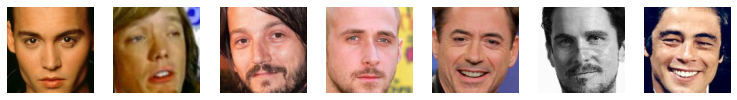

Translated (Actor -> Actress) Images


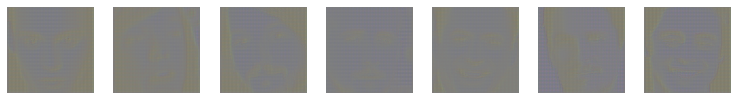

Translated reverse ( Fake Actress -> Fake Actor)


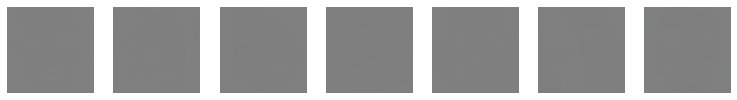

----------------------------------------------------------------------------------------------------
Input Actress Images


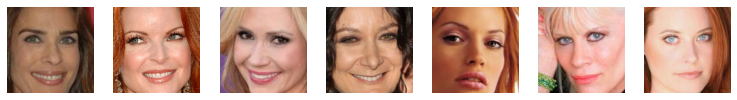

Translated (Actress -> Actor) Images


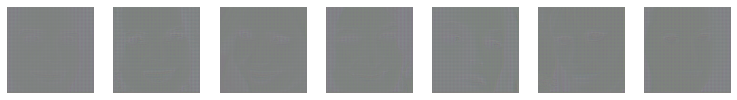

Translated reverse (Fake Actor -> Fake Actress)


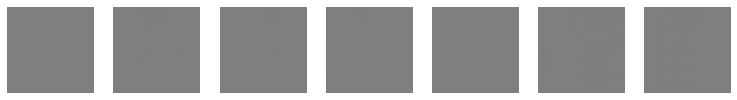

Epoch:0, Step:0, DA-Loss:9.611, DA-Acc:56.250, DB-Loss:9.226, DB-Acc:50.781, G-Loss:5.024
Epoch:0, Step:50, DA-Loss:0.362, DA-Acc:64.062, DB-Loss:0.510, DB-Acc:64.844, G-Loss:2.492
Epoch:0, Step:100, DA-Loss:0.207, DA-Acc:85.156, DB-Loss:0.264, DB-Acc:77.344, G-Loss:2.191
Epoch:0, Step:150, DA-Loss:0.147, DA-Acc:90.625, DB-Loss:0.151, DB-Acc:79.688, G-Loss:2.037
Input Actor Images


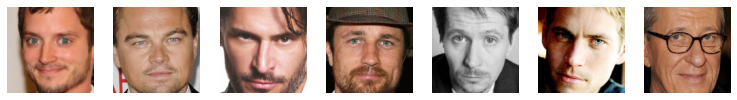

Translated (Actor -> Actress) Images


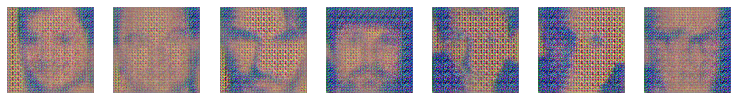

Translated reverse ( Fake Actress -> Fake Actor)


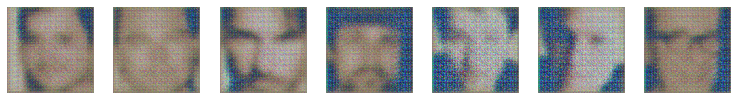

----------------------------------------------------------------------------------------------------
Input Actress Images


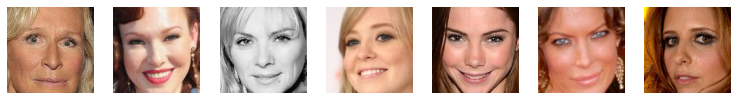

Translated (Actress -> Actor) Images


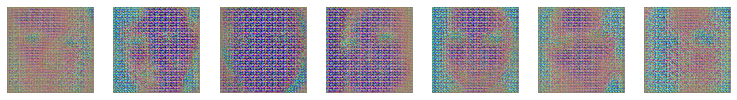

Translated reverse (Fake Actor -> Fake Actress)


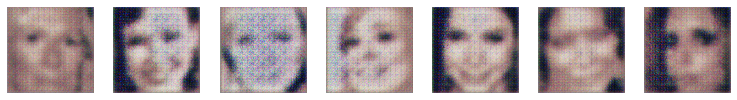

Epoch:0, Step:200, DA-Loss:0.089, DA-Acc:92.969, DB-Loss:0.092, DB-Acc:91.406, G-Loss:1.696
Epoch:0, Step:250, DA-Loss:0.125, DA-Acc:92.969, DB-Loss:0.098, DB-Acc:92.188, G-Loss:1.381
Epoch:0, Step:300, DA-Loss:0.057, DA-Acc:97.656, DB-Loss:0.074, DB-Acc:92.969, G-Loss:1.448
Epoch:0, Step:350, DA-Loss:0.070, DA-Acc:96.094, DB-Loss:0.068, DB-Acc:96.875, G-Loss:1.495
Input Actor Images


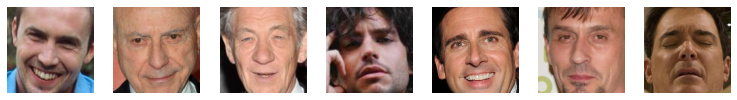

Translated (Actor -> Actress) Images


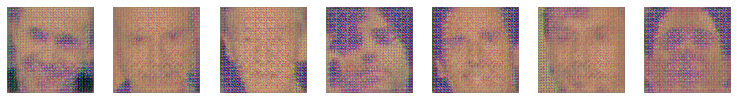

Translated reverse ( Fake Actress -> Fake Actor)


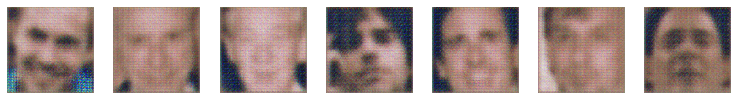

----------------------------------------------------------------------------------------------------
Input Actress Images


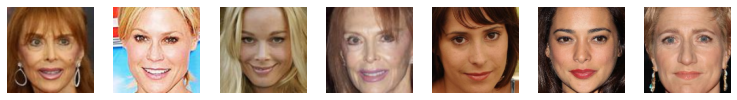

Translated (Actress -> Actor) Images


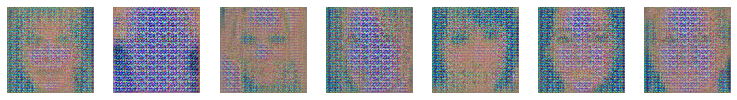

Translated reverse (Fake Actor -> Fake Actress)


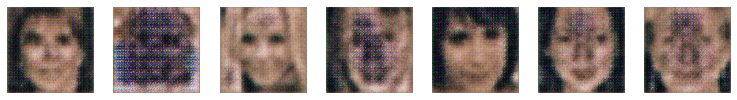

Epoch:0, Step:400, DA-Loss:0.259, DA-Acc:83.594, DB-Loss:0.106, DB-Acc:94.531, G-Loss:1.633
Epoch:0, Step:450, DA-Loss:0.140, DA-Acc:87.500, DB-Loss:0.062, DB-Acc:96.875, G-Loss:1.383
Epoch:0, Step:500, DA-Loss:0.223, DA-Acc:80.469, DB-Loss:0.070, DB-Acc:96.875, G-Loss:1.431
Epoch:0, Step:550, DA-Loss:0.139, DA-Acc:85.156, DB-Loss:0.106, DB-Acc:89.844, G-Loss:1.331
Input Actor Images


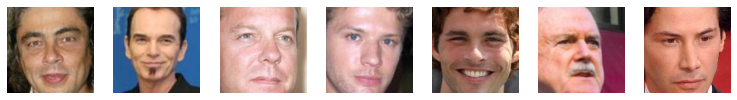

Translated (Actor -> Actress) Images


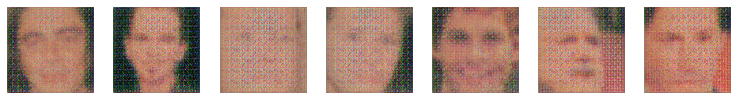

Translated reverse ( Fake Actress -> Fake Actor)


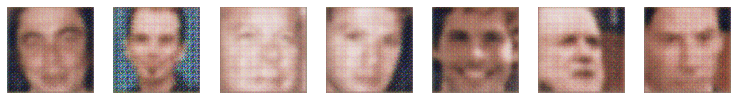

----------------------------------------------------------------------------------------------------
Input Actress Images


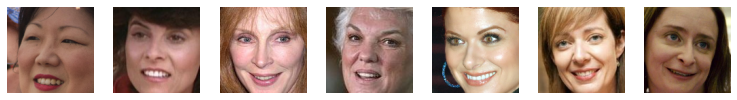

Translated (Actress -> Actor) Images


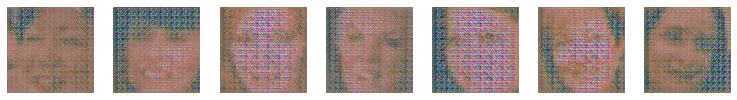

Translated reverse (Fake Actor -> Fake Actress)


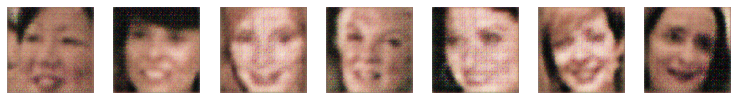

Epoch:0, Step:600, DA-Loss:0.111, DA-Acc:86.719, DB-Loss:0.103, DB-Acc:88.281, G-Loss:1.602
Epoch:0, Step:650, DA-Loss:0.110, DA-Acc:85.938, DB-Loss:0.051, DB-Acc:100.000, G-Loss:1.190
Epoch:0, Step:700, DA-Loss:0.050, DA-Acc:97.656, DB-Loss:0.098, DB-Acc:94.531, G-Loss:1.232
Epoch:0, Step:750, DA-Loss:0.039, DA-Acc:99.219, DB-Loss:0.030, DB-Acc:100.000, G-Loss:1.396
Input Actor Images


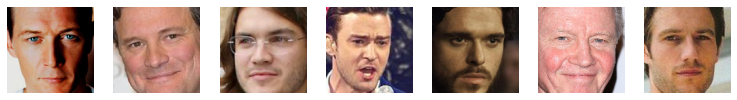

Translated (Actor -> Actress) Images


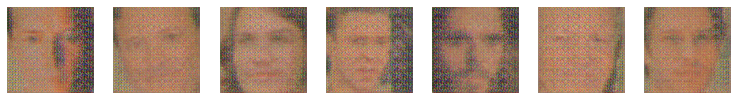

Translated reverse ( Fake Actress -> Fake Actor)


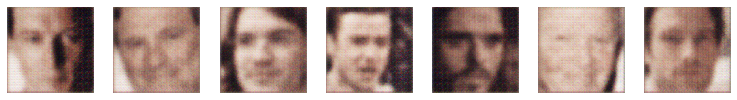

----------------------------------------------------------------------------------------------------
Input Actress Images


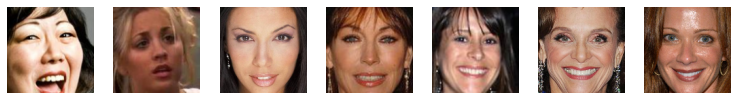

Translated (Actress -> Actor) Images


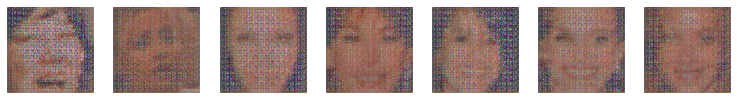

Translated reverse (Fake Actor -> Fake Actress)


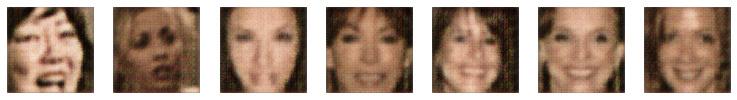

Epoch:0, Step:800, DA-Loss:0.071, DA-Acc:93.750, DB-Loss:0.108, DB-Acc:92.188, G-Loss:1.218
Epoch:0, Step:850, DA-Loss:0.096, DA-Acc:99.219, DB-Loss:0.055, DB-Acc:95.312, G-Loss:1.229
Epoch:0, Step:900, DA-Loss:0.075, DA-Acc:94.531, DB-Loss:0.040, DB-Acc:98.438, G-Loss:1.726
Epoch:0, Step:950, DA-Loss:0.065, DA-Acc:97.656, DB-Loss:0.236, DB-Acc:76.562, G-Loss:1.245
Input Actor Images


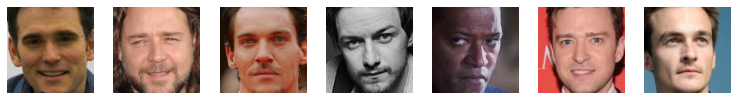

Translated (Actor -> Actress) Images


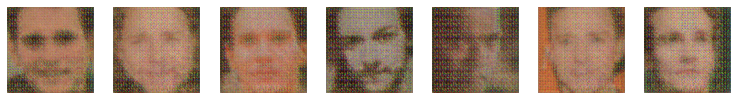

Translated reverse ( Fake Actress -> Fake Actor)


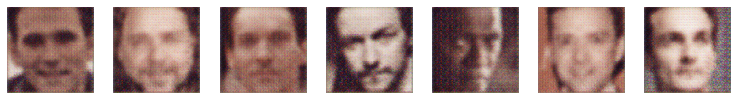

----------------------------------------------------------------------------------------------------
Input Actress Images


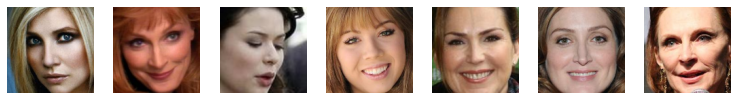

Translated (Actress -> Actor) Images


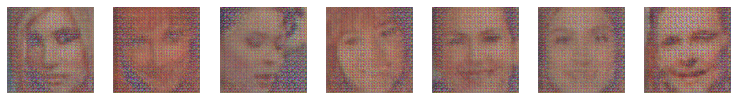

Translated reverse (Fake Actor -> Fake Actress)


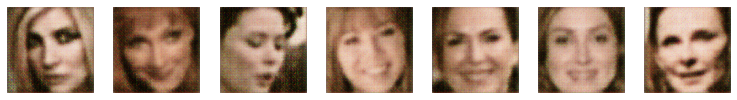

Epoch:1, Step:0, DA-Loss:0.074, DA-Acc:99.219, DB-Loss:0.044, DB-Acc:99.219, G-Loss:1.489
Epoch:1, Step:50, DA-Loss:0.051, DA-Acc:98.438, DB-Loss:0.065, DB-Acc:96.094, G-Loss:1.035
Epoch:1, Step:100, DA-Loss:0.066, DA-Acc:98.438, DB-Loss:0.044, DB-Acc:99.219, G-Loss:1.292
Epoch:1, Step:150, DA-Loss:0.047, DA-Acc:98.438, DB-Loss:0.045, DB-Acc:98.438, G-Loss:1.487
Input Actor Images


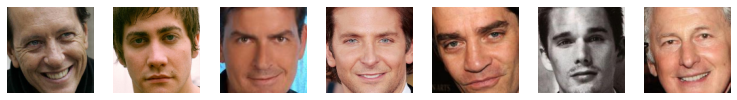

Translated (Actor -> Actress) Images


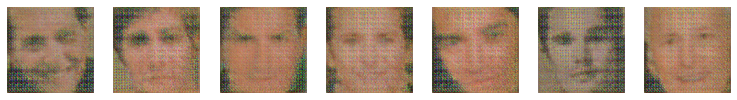

Translated reverse ( Fake Actress -> Fake Actor)


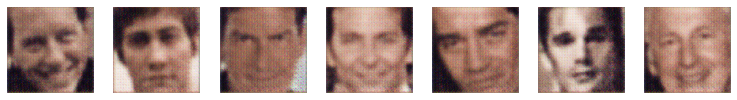

----------------------------------------------------------------------------------------------------
Input Actress Images


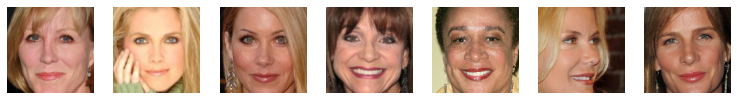

Translated (Actress -> Actor) Images


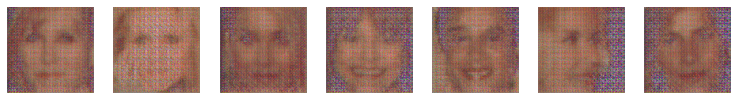

Translated reverse (Fake Actor -> Fake Actress)


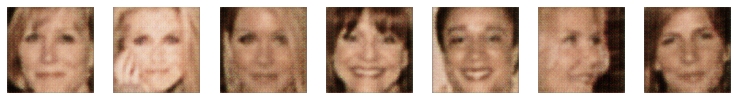

Epoch:1, Step:200, DA-Loss:0.028, DA-Acc:100.000, DB-Loss:0.070, DB-Acc:94.531, G-Loss:1.430
Epoch:1, Step:250, DA-Loss:0.030, DA-Acc:100.000, DB-Loss:0.020, DB-Acc:100.000, G-Loss:1.272
Epoch:1, Step:300, DA-Loss:0.042, DA-Acc:100.000, DB-Loss:0.016, DB-Acc:100.000, G-Loss:1.083
Epoch:1, Step:350, DA-Loss:0.058, DA-Acc:97.656, DB-Loss:0.053, DB-Acc:99.219, G-Loss:1.059
Input Actor Images


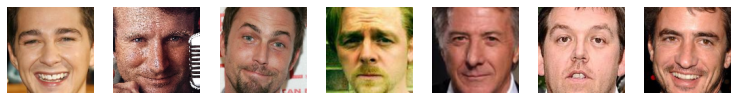

Translated (Actor -> Actress) Images


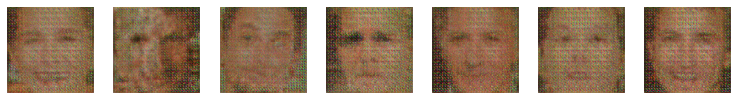

Translated reverse ( Fake Actress -> Fake Actor)


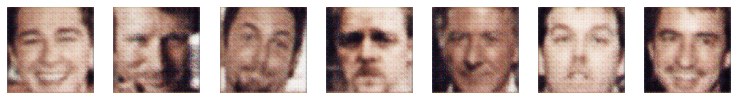

----------------------------------------------------------------------------------------------------
Input Actress Images


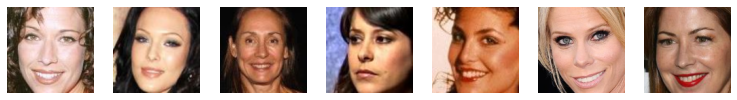

Translated (Actress -> Actor) Images


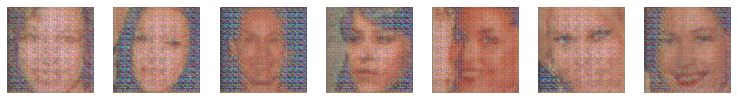

Translated reverse (Fake Actor -> Fake Actress)


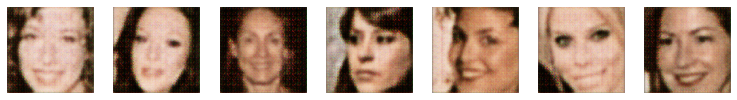

Epoch:1, Step:400, DA-Loss:0.017, DA-Acc:100.000, DB-Loss:0.025, DB-Acc:100.000, G-Loss:1.295
Epoch:1, Step:450, DA-Loss:0.022, DA-Acc:100.000, DB-Loss:0.030, DB-Acc:100.000, G-Loss:1.140
Epoch:1, Step:500, DA-Loss:0.065, DA-Acc:96.094, DB-Loss:0.056, DB-Acc:95.312, G-Loss:1.131
Epoch:1, Step:550, DA-Loss:0.048, DA-Acc:96.875, DB-Loss:0.103, DB-Acc:89.062, G-Loss:1.185
Input Actor Images


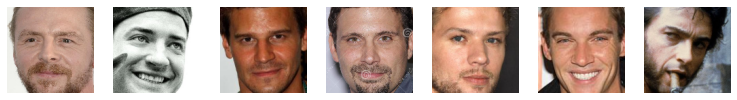

Translated (Actor -> Actress) Images


KeyboardInterrupt: ignored

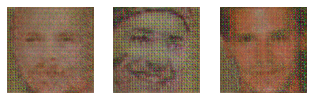

In [39]:
epochs = 500
batch_size = 1
steps = 1000

for i in range(0, epochs):
    for j in range(steps):  
        if j%200 == 0:
            show_generator_results_actor_to_actress(generator_network_AB, generator_network_BA)
            print ("-"*100)
            show_generator_results_actress_to_actor(generator_network_AB, generator_network_BA)

        # A == Actor
        # B == Actress
        domain_A_images = get_actor_samples(batch_size)
        domain_B_images = get_actress_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        discriminator_network_B.trainable=False
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        discriminator_network_A.trainable=False
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False

        # Updating Generator weights
        loss_g = disco_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_B_images, domain_A_images, domain_A_images, domain_B_images])
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            